<a href="https://colab.research.google.com/github/BMClab/papers/blob/master/h2a_age_spt/notebooks/speed_age_spt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Effects of age and speed on step length and cadence during walking

> [Laboratory of Biomechanics and Motor Control](http://pesquisa.ufabc.edu.br/bmclab/)  
> Federal University of ABC, Brazil

## Introduction

This notebook contains data analysis to investigate the effects of speed and age on step length and cadence.

The experimental data are taken from an open dataset (Fukuchi et al., 2018). This dataset contains raw and processed data from standard 3-D gait analysis of healthy volunteers walking in both overground and treadmill in a range of speeds.

## Python setup

In [ ]:
import os, sys
from pathlib import Path
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
from tqdm import tqdm

if "google.colab" in sys.modules:
    %pip install -q pingouin
    %pip install -q watermark

import pingouin as pg

%load_ext watermark

### Environment

In [ ]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.1)
#palette = sns.color_palette(palette='Set1')  # tab10
#palette[0], palette[1] = palette[1], palette[0]
#sns.set_palette(palette=palette)
pd.set_option('display.precision', 3)  # number of decimal places for the environment
pd.set_option('future.no_silent_downcasting', True)

# Run bootstrap (very slow)
run_bootstrap = False
# number of bootstraps to be performed
n_boots = 100
# significance level
alpha = 0.05
# colors
#colors = sns.color_palette()
colors = plotly.colors.DEFAULT_PLOTLY_COLORS
colors2 = [tuple(np.fromstring(c[4:-1], sep=',')/255) for c in colors]

%watermark -u -t -d -m -v --iversions

Last updated: 2025-12-12 19:33:33

Python implementation: CPython
Python version       : 3.13.11
IPython version      : 9.8.0

Compiler    : GCC 14.3.0
OS          : Linux
Release     : 6.14.0-15-generic
Machine     : x86_64
Processor   : 
CPU cores   : 16
Architecture: 64bit

pandas     : 2.3.3
numpy      : 2.3.5
sys        : 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:24:03) [GCC 14.3.0]
plotly     : 6.5.0
pingouin   : 0.5.5
scipy      : 1.16.3
matplotlib : 3.10.7
statsmodels: 0.14.6
tqdm       : 4.67.1
seaborn    : 0.13.2



### Helping functions

In [ ]:
def ttest(df, feature, group, levels=None, alpha=.05):
    """t-test statistcs for dataframe columns using the pingouin library.
    """
    stats = []
    if levels is None:
        levels = df[group].unique()
    if len(levels) != 2:
        raise Exception('Incorrect number of levels: {}'.format(len(levels)))
    for f in feature:
        x = df[df[group] == levels[0]][f]
        y = df[df[group] == levels[1]][f]
        stat = pg.ttest(x, y, confidence=1-alpha)
        stat.index = [f]
        diff = np.round(100 * (np.mean(x) - np.mean(y)) / np.mean(y), 0)
        diff = pd.DataFrame(data=diff, index=[f], columns=['%diff'], dtype=int)
        stat = pd.concat([stat, diff], axis=1)
        stats.append(stat)

    stats = [df.dropna(axis=1, how='all') for df in stats]
    stats = pd.concat(stats, axis=0)
    stats.drop(columns=['alternative', 'BF10', 'power'], inplace=True)
    stats.index.name = '{}-{}'.format(*levels)
    display(stats.style.format({'p-val': '{:.3f}'}).apply(sig_red, subset='p-val', axis=1))
    return stats


def normtest(df, feature, group, alpha=alpha):
    """Normality test for dataframe columns using the pingouin library.
    """
    levels = df[group].unique()
    for level in levels:
        test = pg.normality(df[df[group] == level][feature], method='normaltest')
        test.index.name = level
        display(test.style.format({'pval': '{:.3f}'}).apply(sig_red, axis=1))


def normality(df):
    """Get the p-val of the normality test using the pingouin library.
    """
    return pg.normality(df)['pval']


def describe(df, feature, group, stat=['count', 'mean', 'std', 'min', 'max', normality]):
    """Descriptive statistics for dataframe columns.
    """
    col = [('Young', 'normality'), ('Older', 'normality')]
    x = df.groupby(group)[feature].agg(stat).stack(future_stack=True).transpose().style.apply(sig_red, subset=col)
    display(x)
    return x


def sig_red(col, alpha=alpha):
    """Returns string 'color: red' for `col` < `alpha`, black otherwise.
    """
    col = np.array([(float(x[1:]) if isinstance(x, str) else float(x))
                    if len(str(x)) else np.nan for x in col])

    is_sig = col < alpha
    return ['color: red' if x else 'color: black' for x in is_sig]


def regression(fit_ml, fit_re, names):
    """Get results from linear regression as list.

    results = ['Response', 'Coef', 'CI', 'p', 'Coef', 'CI', 'p', Coef', 'CI', 'p',
               'llf', 'AIC', 'R2']
    """
    # print(fit_re.model.exog_names)
    if names is None:
        names = fit_re.model.exog_names[1:]
    results = [np.nan]*(1 + len(names)*3 + 3)
    # response
    results[ 0] = fit_re.model.endog_names
    # log-likelihood function
    results[-3] = '{:.1f}'.format(fit_ml.llf)
    # Akaike information criterion
    results[-2] = '{:.1f}'.format(fit_ml.aic)
    # marginal R2, proportion of variance explained by the fixed factor(s) alone
    results[-1] = '{:.2f}'.format(np.corrcoef(fit_re.model.endog, fit_re.predict())[0, 1]**2)
    # conditional R2, proportion of variance explained by both the fixed and random factors
    #results[-1] = np.round(np.corrcoef(fit_re.model.endog , fit_re.fittedvalues)[0, 1]**2, 2)
    for name in fit_re.model.exog_names[1:]:
        idx = names.index(name)
        # fitted fixed-effects coefficients
        results[3*idx+1] = '{:.2f}'.format(fit_re.params[name])
        # confidence interval for the fitted parameters
        ci = fit_re.conf_int().loc[name].values
        results[3*idx+2] = '[{:.2f}, {:.2f}]'.format(ci[0], ci[1])
        # two-tailed p values for the t-stats of the params
        if fit_re.pvalues[name] < 0.0001:
            results[3*idx+3] = '< 0.0001'
        else:
            results[3*idx+3] = '{:.4f}'.format(fit_re.pvalues[name])

    return results


def runmodels(data, predictors, responses, groups, names, mixed=True, show=True):
    """Run OLS or mixed linear regression models.
    """
    import warnings
    from statsmodels.tools.sm_exceptions import ConvergenceWarning
    warnings.simplefilter('ignore', ConvergenceWarning)

    fit_ml = []
    fit_re = []
    models = []
    i = 0
    print('Running regression models...')
    for response in responses:
        for predictor in predictors:
            eq = '{} ~ {}'.format(response, predictor)
            print(response, predictor)
            if mixed:
                md = smf.mixedlm(formula=eq, data=data, groups=groups)
            else:
                md = smf.ols(formula=eq, data=data)
            # use ML method to estimate AIC and llf
            fit_ml.append(md.fit(reml=False))
            # use REML method to get unbiased estimations of the coefficients
            fit_re.append(md.fit(reml=True))
            models.append(regression(fit_ml[-1], fit_re[-1], names=names))
            if mixed:
                text = 'converged' if fit_re[-1].converged else 'didn\'t converge'
            if show:
                if mixed:
                    print('Model {:2}: {} {}.'.format(i, eq, text))
                else:
                    print('Model {:2}: {}.'.format(i, eq))
                #display(fit_re[-1].summary())
            i += 1
    if show:
        print('...done.')

    return models, fit_ml, fit_re


def display_table(models, names, del_name_idx=None, filename=None):
    """Display rich table with stats from regression models.
    """
    h0, h1, h2 = ['Feature'], ['Feature'], ['Feature']
    h0.extend(['Predictor']*3*len(names))
    for name in names:
        h1.extend(name*3)
    h2.extend(['Coef', 'CI', 'p-value']*len(names))
    h0.extend(['LLF', 'AIC', 'R2'])
    h1.extend(['LLF', 'AIC', 'R2'])
    h2.extend(['LLF', 'AIC', 'R2'])
    table = pd.DataFrame(data=models)
    table.columns=[h0, h1, h2]
    table.replace({np.nan: ''}, inplace=True)
    if del_name_idx is not None:
        for col in del_name_idx:
            table = table.drop(columns=names[col], level=1)
    if filename is not None:
        try:
            table.to_csv(f'{path2}{os.sep}{filename}', sep='\t', index=False)
        except:
            print('Table not saved in the cloud.')
    table = table.style \
            .apply(sig_red, subset=[c for c in table.columns if c[-1] == 'p-value']) \
            .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    return table


def plot_residuals(fit=None, residuals=None, kind='marginal', x=None,
                   xlabel=None, ylabel=None, alpha=0.05, hover=None):
    """Scater plot, histogram and Q-Q plot for testing residuals.

    This function generates three subplots (1x3):
    1. Scatter plot of the residuals versus predictor variables.
    2. Histogram of the residuals and the expected normal function.
    3. Q-Q plot.

    On the third plot are also shown the statistic and p-value of the
    Shapiro-Wilk test for normality. These values are also returned as output
    of the function.

    Parameters
    ----------
    fit: statsmodels regression results or None, optional (default=None)
        `fit` is a mod.fit() structure
        See https://www.statsmodels.org/stable/regression.html
        The residuals and predictor values are taken from this parameter.

    residuals: 1-D array_like or None, optional (default=None)
        The residuals to test the normality. Enter this parameter only if
        `fit` is not inputed.

    kind: {'marginal', 'conditional'}, optional (default='marginal')
        Which kind of residuals to test (only if `fit` is inputed).
        'marginal': residuals from fixed effects
        'conditional': residuals from fixed and random effects

    x: 1-D array_like or None, optional (default=None)
        The predictor values.

    xlabel: string or None, optional (default=None)
        The predictor label.

    ylabel: string or None, optional (default=None)
        The response label.

    alpha: float, optional (default=0.05)
        The significance level

    hover: tuple (string, 1-D array_like) or None, optional (default=None)
        Information to show when hovering the data in the first plot.
        See the examples.


    Returns
    -------
    statistic: float
        The statistic of the Shapiro-Wilk test for normality.
    p-value: float
        The p-value of the null-hypothesis test for normality.

    Notes
    -----
    https://www.statsmodels.org/stable/_modules/statsmodels/regression/mixed_linear_model.html
    fit.model.fit().predict() or fit.predict() only reflect
     fixed effects mean structure of the model.
    fit.model.fit().fittedvalues or fit.fittedvalues reflect the mean
     structure specified by fixed effects and predicted random effects.

    Examples
    --------
    >>> residuals = np.random.normal(loc=0.0, scale=1.0, size=1000)
    >>> plot_residuals(residuals=residuals)
    >>> residuals = np.random.lognormal(mean=1.0, sigma=0.5, size=100)
    >>> plot_residuals(residuals=residuals, xlabel= 'X', ylabel='Y')
    >>> residuals = np.random.lognormal(mean=1.0, sigma=0.5, size=10)
    >>> plot_residuals(residuals=residuals, hover=('Datum', np.arange(10)))
    """

    import numpy as np
    import scipy as sp
    import plotly
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    import plotly.figure_factory as ff

    if fit is not None:
        # fit.model.fit().predict() or fit.predict() only reflect
        #  fixed effects mean structure of the model.
        # fit.model.fit().fittedvalues or fit.fittedvalues reflect the mean
        #  structure specified by fixed effects and predicted random effects.
        if kind == 'marginal':
            residuals = fit.model.endog - fit.model.fit().predict()
        elif kind == 'conditional':
            residuals = fit.model.endog - fit.model.fit().fittedvalues
        else:
            raise ValueError("Valid options for 'kind': 'marginal' or 'conditional'.")
        x = fit.model.exog[:, 1]
    else:
        if residuals is None:
            raise ValueError('If fit is None, residuals cannot be None.')
        if x is None:
            x = np.arange(0, len(residuals))
    if xlabel is None:
        xlabel = 'Predictor'
    if ylabel is None:
        ylabel = 'Response'

    # normality of residuals test
    W, p = sp.stats.shapiro(residuals)  # Shapiro-Wilk test
    if p < 0.001:
        p_str = 'p < 0.001'
    else:
        p_str = 'p = {:.3f}'.format(p)
    # plots
    fig = make_subplots(rows=1, cols=3, horizontal_spacing=0.1,
                        subplot_titles=('Scatter plot', 'Histogram', 'Q-Q plot'))
    # scatter plot
    if hover is not None:
        label, data = hover[0], hover[1]
        template = ['<b>{}: '.format(label) + '%{customdata}</b> <br>' +
                    '{}: '.format(xlabel) + '%{x} <br>Residual: %{y} ']
        fig.add_trace(go.Scatter(x=x, y=residuals, mode='markers',
                                 marker=dict(color='blue'),
                                 customdata=data,
                                 hovertemplate=template[0],
                                 name=''),
                      row=1, col=1)
    else:
        fig.add_trace(go.Scatter(x=x, y=residuals, mode='markers', name='',
                                 marker=dict(color='blue')), row=1, col=1)
    if min(residuals)<=0 and max(residuals)>=0:
        fig.add_hline(y=0, line=dict(width=2, color='rgba(0,0,0,.5)'), row=1, col=1)
    # histogram
    fig.add_trace(go.Histogram(x=residuals, marker_color='blue', name='',
                               histnorm='probability density'), row=1, col=2)
    norm = ff.create_distplot([residuals], group_labels=[''],
                              curve_type='normal', show_rug=False).data[1]
    fig.add_trace(go.Scatter(x=norm['x'], y=norm['y'], mode = 'lines', name='',
                             line=dict(width=3, color='red')), row=1, col=2)
    # Q-Q plot
    qq = sp.stats.probplot(residuals, dist='norm')
    qqx = np.array([qq[0][0][0], qq[0][0][-1]])
    fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers', name='',
                             marker=dict(color='blue')), row=1, col=3)
    fig.add_trace(go.Scatter(x=qqx, y=qq[1][1] + qq[1][0]*qqx, mode='lines', name='',
                             line=dict(width=3, color='red')), row=1, col=3)
    fig.add_annotation(text='W = {:.2f}<br>{}'.format(W, p_str),
                       xref='x domain', yref='y domain', align='left', valign='top',
                       x=0.02, y=0.98, showarrow=False, row=1, col=3)
    # x and y axes properties
    fig.update_xaxes(title_text=xlabel, row=1, col=1)
    fig.update_xaxes(title_text='Residuals', row=1, col=2)
    fig.update_xaxes(title_text='Normal theoretical quantiles', row=1, col=3)
    fig.update_yaxes(title_text='Residuals', row=1, col=1)
    fig.update_yaxes(title_text='Probability density', row=1, col=2)
    fig.update_yaxes(title_text='Observed data quantiles', row=1, col=3)

    text='Normality tests for residuals of {} &times; {}'.format(ylabel, xlabel)
    fig.update_layout(showlegend=False, height=400, font_color='black',
                      title=dict(text=text, x=.5, xanchor='center', yanchor='top',
                                 font=dict(size=20)))
    fig.show()
    print(['We {}reject the null hypothesis that the residuals come from a population' +
           ' with normal distribution\n(Shapiro-Wilk test: W({}) = {:.2f}, {}).'
          ][0].format('failed to ' if p>alpha else '', len(x), W, p_str))

    return W, p


def bootstrap(df, df2, response, predictor, groups, n_boots=1000):
    """Bootstrap observations for parameter estimation of linear mixed effects model.
    """
    y_boot = np.zeros((df2.shape[0], n_boots))
    eq = '{} ~ {}'.format(response, predictor)
    for i in tqdm(range(n_boots)):
        y_boot[:, i] = smf.mixedlm(formula=eq,
                                   groups=groups,
                                   data=df.sample(n=df.shape[0], replace=True)
                                  ).fit().predict(df2)
    return y_boot


def boxplots(df, var=['Speed', 'Cadence', 'StepLength']):
    """Boxplots of variables var in df
    """
    fig, axs = plt.subplots(1, len(var), figsize=(12, 3),
                            gridspec_kw={'hspace':.1, 'wspace':.5})
    for ax, v in zip(axs, var):
        sns.boxplot(x='AgeGroup', y=v, data=df, fliersize=9, ax=ax)
        sns.swarmplot(x='AgeGroup', y=v, data=df, ax=ax, color='gray')
        ax.set_title(v)
        ax.set_ylabel('')
    plt.show()

### Dataset location

In [ ]:
# file with discrete variables calculated by 'Walking speed torque  .ipynb'
path2 = f'.{os.sep}..{os.sep}data'
filename = 'h2a_allspeeds_43subs.csv'
if not os.path.isfile((path2 := Path(path2)) / filename):
    print('Dataset not found locally. It will be loaded from the GitHub repo.')
    # REMOTE
    path2 = 'https://raw.githubusercontent.com/BMClab/datasets/master/H2A/data'

print(f'Dataset location: {path2}')
filename = f'{path2}{os.sep}{filename}'

Dataset location: ../data


## Read data

In [ ]:
df = pd.read_csv(filename)
df['Cadence'] = df['Cadence'] / 60
df

,Subject,AgeGroup,Gender,Age,Height,Mass,BMI,LegLength,SpeedCat,SpeedComf,Speed,StepLength,Cadence,H2A_M,H2A_I,H2A_W
0,1,Young,M,25,1.725,74.3,24.970,0.89,V1,1.21,0.49,0.434,1.130,0.436,0.375,1.344
1,1,Young,M,25,1.725,74.3,24.970,0.89,V2,1.21,0.67,0.505,1.361,0.391,0.347,2.195
2,1,Young,M,25,1.725,74.3,24.970,0.89,V3,1.21,0.85,0.593,1.446,0.472,0.329,2.028
3,1,Young,M,25,1.725,74.3,24.970,0.89,V4,1.21,1.03,0.623,1.662,0.556,0.383,1.534
4,1,Young,M,25,1.725,74.3,24.970,0.89,V5,1.21,1.21,0.647,1.881,0.600,0.374,1.592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,50,Older,F,68,1.545,50.3,21.072,0.77,V2,1.23,0.68,0.408,1.644,0.334,0.261,1.973
254,50,Older,F,68,1.545,50.3,21.072,0.77,V3,1.23,0.86,0.476,1.805,0.435,0.297,1.851
255,50,Older,F,68,1.545,50.3,21.072,0.77,V4,1.23,1.05,0.518,2.027,0.502,0.365,1.351
256,50,Older,F,68,1.545,50.3,21.072,0.77,V5,1.23,1.23,0.580,2.120,0.602,0.415,1.111


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject     258 non-null    int64  
 1   AgeGroup    258 non-null    object 
 2   Gender      258 non-null    object 
 3   Age         258 non-null    int64  
 4   Height      258 non-null    float64
 5   Mass        258 non-null    float64
 6   BMI         258 non-null    float64
 7   LegLength   258 non-null    float64
 8   SpeedCat    258 non-null    object 
 9   SpeedComf   258 non-null    float64
 10  Speed       258 non-null    float64
 11  StepLength  258 non-null    float64
 12  Cadence     258 non-null    float64
 13  H2A_M       258 non-null    float64
 14  H2A_I       258 non-null    float64
 15  H2A_W       258 non-null    float64
dtypes: float64(11), int64(2), object(3)
memory usage: 32.4+ KB


### Read summary data

In [ ]:
data_dict = {}
try:
    if not run_bootstrap:
        if os.getenv("COLAB_RELEASE_TAG"):
            wget.download("https://github.com/BMClab/datasets/blob/master/H2A/data/data_dict.pkl?raw=true")
            data_file = open('data_dict.pkl', 'rb')
        else:
            data_file = open(f'{path2}{os.sep}data_dict.pkl', 'rb')
        data_dict = pickle.load(data_file)
        print(data_dict.keys())
    else:
        print('Analysis and bootstrap will be performed.')
except:
    print('File with summary data not found; analysis and bootstrap will be performed.')

Analysis and bootstrap will be performed.


## Basic characteristics and age-group comparison

In [ ]:
# number of subjects in each group
Ny, No = df.drop_duplicates(subset='Subject')[['Subject', 'AgeGroup']
                                             ].groupby(['AgeGroup']).count().values
display(df.drop_duplicates(subset='Subject', inplace=False)[
        ['Subject', 'AgeGroup', 'Gender']].groupby(['AgeGroup', 'Gender']).count().T)

AgeGroup Older     Young    
Gender       F   M     F   M
Subject      9  12     8  14

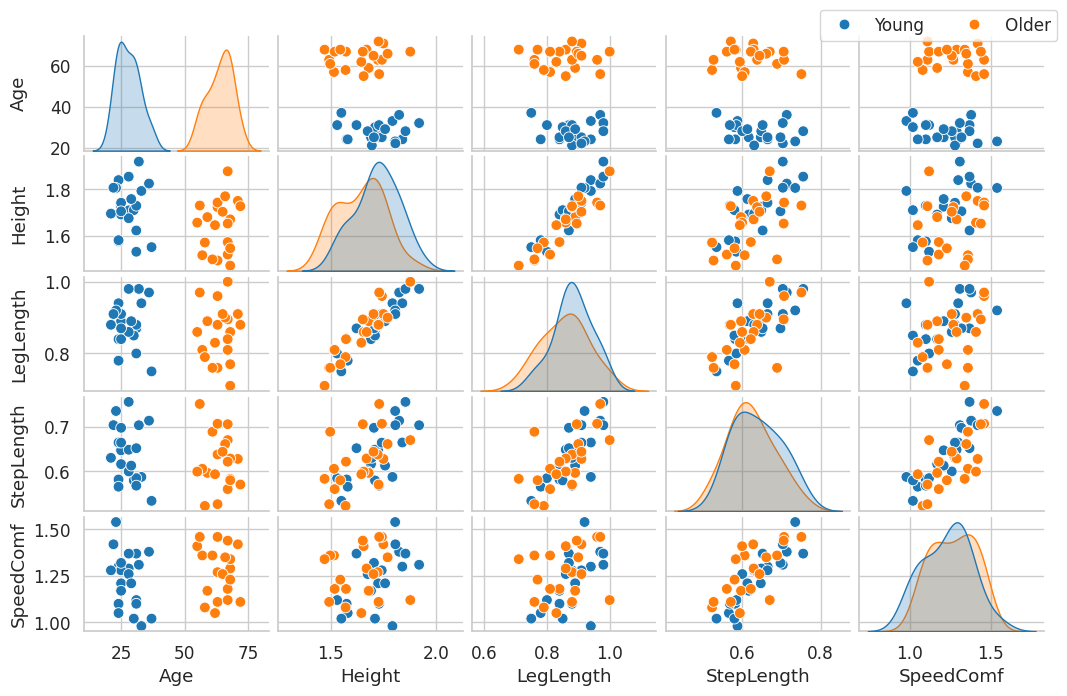

In [ ]:
grid = sns.pairplot(df[df['SpeedCat']=='V5'],
                    vars=['Age', 'Height', 'LegLength', 'StepLength', 'SpeedComf'],
                    diag_kind='auto', hue='AgeGroup', plot_kws={'s':60},
                    height=1.4, aspect=1.4)
handles = grid._legend_data.values()
labels = grid._legend_data.keys()
grid._legend.remove()
grid.fig.legend(handles=handles, labels=labels, loc='upper right', ncol=2,
                bbox_to_anchor=(1, 1.0), bbox_transform=plt.gcf().transFigure)
grid.fig.subplots_adjust(left=.1, right=.98, bottom = 0.1, top=.95, hspace=.05, wspace=.05)
grid.fig.align_ylabels(grid.axes[:, 0])
plt.show()

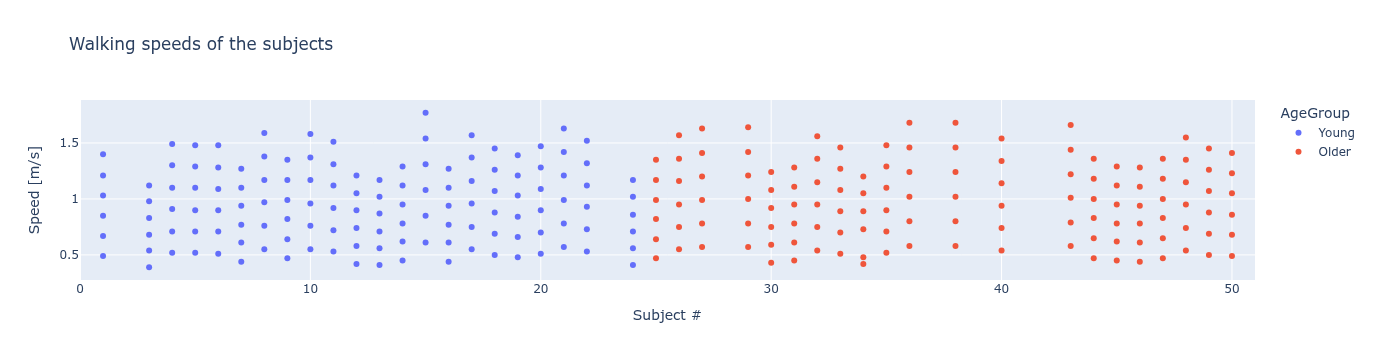

In [ ]:
fig = px.scatter(df, x='Subject', y='Speed', color='AgeGroup',
                 hover_data=['LegLength', 'Cadence', 'StepLength'],
                 labels={'Speed': 'Speed [m/s]', 'Subject': 'Subject #'},
                 range_x=[0, df.Subject.max()+1],
                 title='Walking speeds of the subjects')
fig.show()

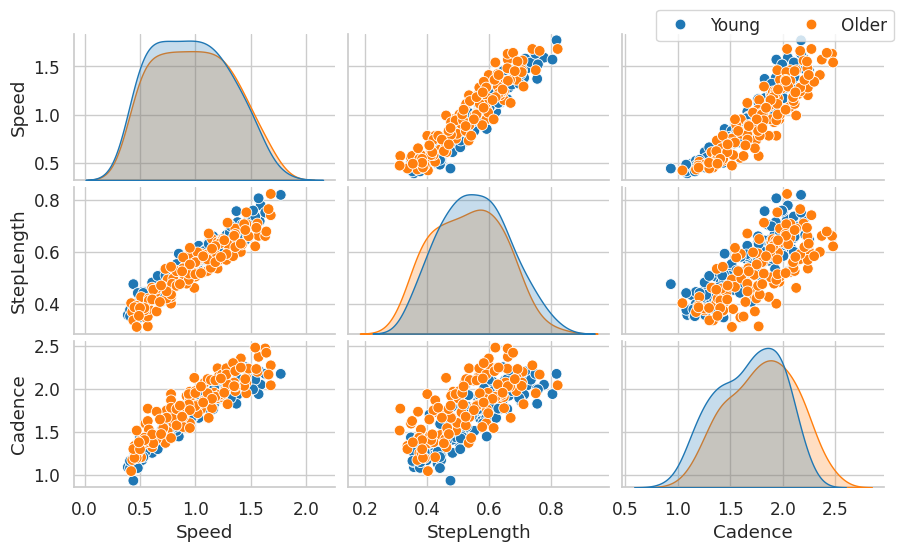

In [ ]:
grid = sns.pairplot(df, vars=['Speed', 'StepLength', 'Cadence'],
                    diag_kind='auto', hue='AgeGroup', plot_kws={'s':60},
                    height=1.8, aspect=1.5)
handles = grid._legend_data.values()
labels = grid._legend_data.keys()
grid._legend.remove()
grid.fig.legend(handles=handles, labels=labels, loc='upper right', ncol=2,
             bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)
grid.fig.subplots_adjust(left=.1, right=.98, bottom = 0.1, top=.94, hspace=.05, wspace=.05)
grid.fig.align_ylabels(grid.axes[:, 0])
plt.show()

In [ ]:
var = ['Age', 'Height', 'Mass', 'BMI', 'LegLength', 'SpeedComf']
table = describe(df.drop_duplicates(subset='Subject'), feature=var, group='AgeGroup')

In [ ]:
stats = ttest(df.drop_duplicates(subset='Subject'), var, 'AgeGroup',
              levels=['Older', 'Young'], alpha=alpha)

,T,dof,p-val,CI95%,cohen-d,%diff
Older-Young,,,,,,
Age,25.447390,40.196112,0.000,[33.26 39. ],7.780884,130
Height,-2.349537,40.458112,0.024,[-0.14 -0.01],0.717961,-4
Mass,-0.755008,39.415278,0.455,[-10.22 4.66],0.231181,-4
BMI,0.911449,39.704846,0.368,[-1.19 3.15],0.276564,4
LegLength,-1.215326,38.449386,0.232,[-0.07 0.02],0.372640,-3
SpeedComf,0.868454,40.897363,0.390,[-0.05 0.12],0.264333,3


## Linear regression models

> Predictors: Age and Speed  
> Responses: StepLength and Cadence

### StepLength

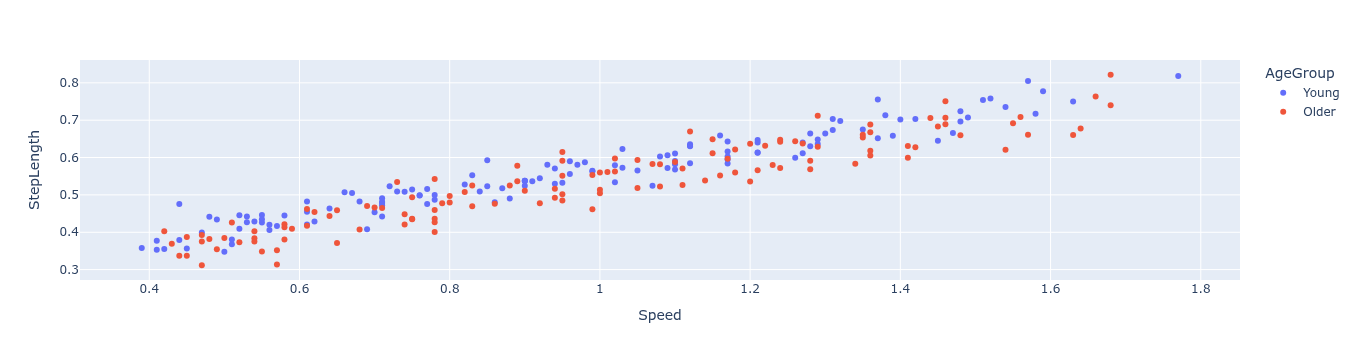

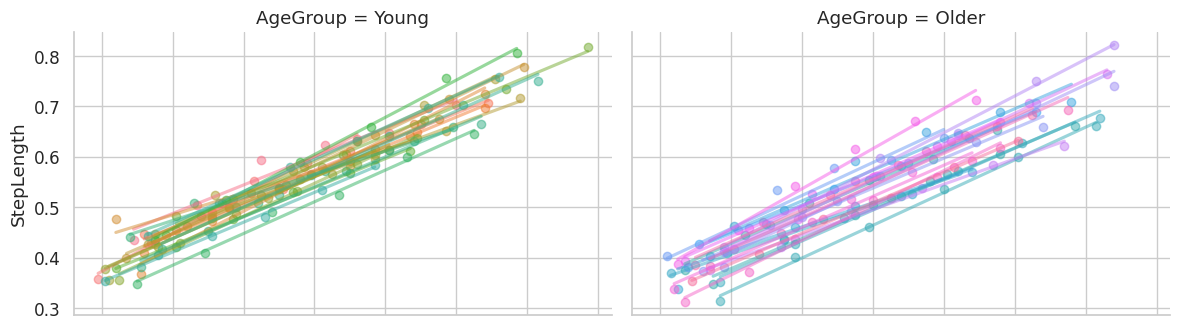

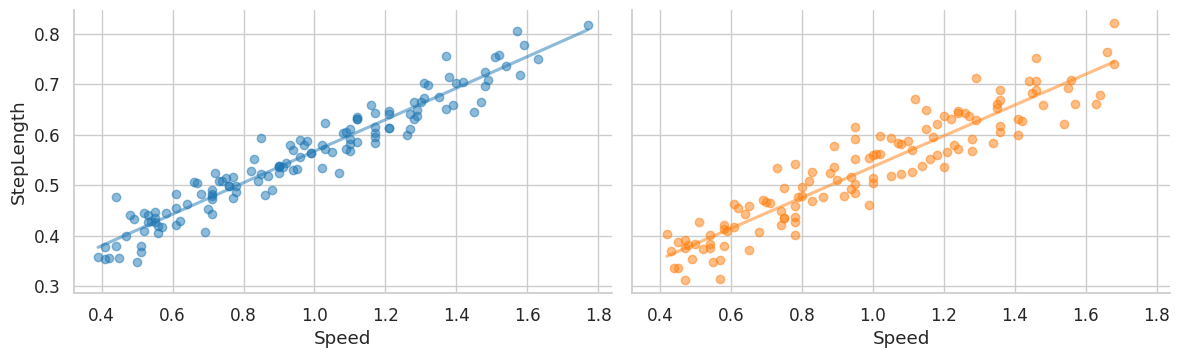

In [ ]:
def plots(df, x, y):
    """Scatter and line plots
    """
    fig = px.scatter(df, x=x, y=y, color='AgeGroup',
                     hover_data=['Subject', 'StepLength', 'Cadence', 'SpeedComf'])
    fig.show()

    grid = sns.lmplot(x=x, y=y, data=df, order=1, hue='Subject', col='AgeGroup',
                      ci=None, robust=False, scatter_kws={'alpha':.5}, line_kws={'alpha':.5},
                      facet_kws={'sharex':True, 'sharey':True}, fit_reg=True, legend=False,
                      height=4, aspect=1.5)
    grid.set(xticklabels=[])
    grid.set_xlabels('')
    plt.show()

    grid = sns.lmplot(x=x, y=y, data=df, order=1, col='AgeGroup', hue='AgeGroup',
                      ci=None, robust=False, scatter_kws={'alpha':.5}, line_kws={'alpha':.5},
                      facet_kws={'sharex':True, 'sharey':True}, fit_reg=True, legend=False,
                      height=4, aspect=1.5)
    grid.set_titles(col_template='')
    plt.show()


plots(df, x='Speed', y='StepLength')

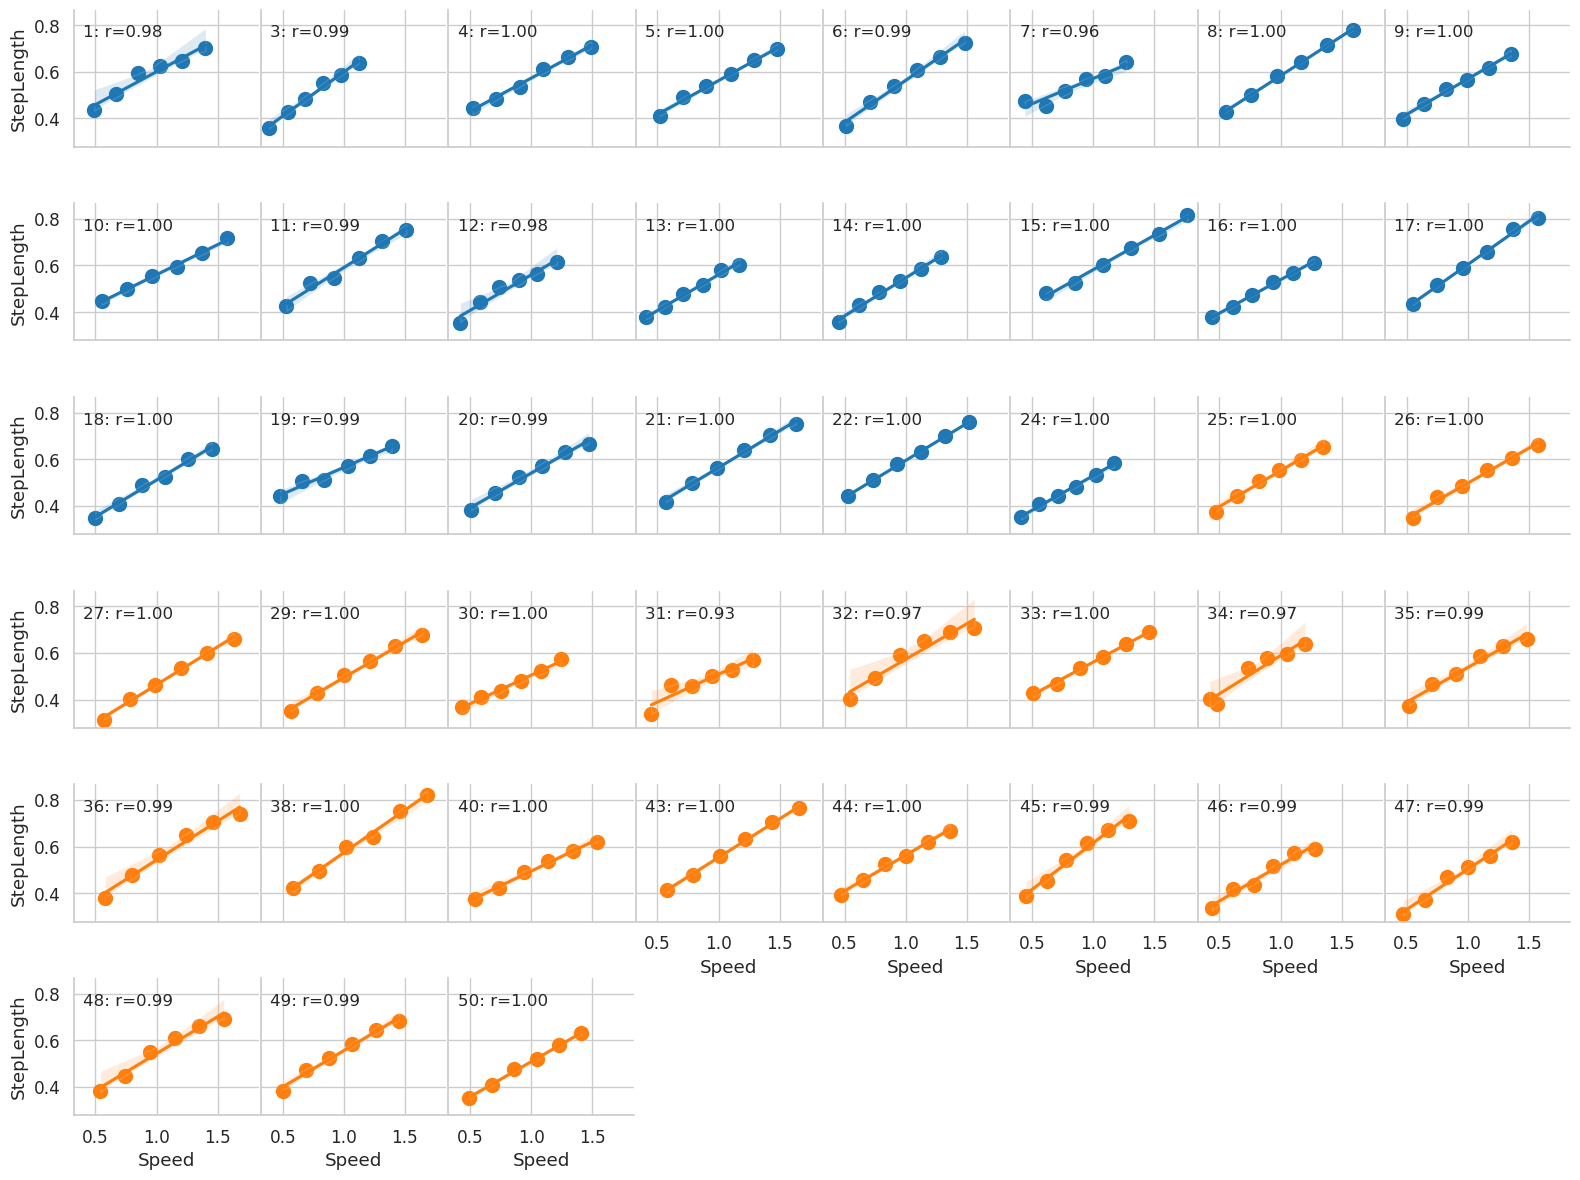

In [ ]:
def plots2(df, x, y):
    """Scatter and line plots
    """
    grid = sns.lmplot(x=x, y=y, data=df, hue='AgeGroup', col='Subject',
                      col_wrap=8, ci=100*(1-alpha), robust=False, fit_reg=True,
                      height=2, aspect=1, scatter_kws={'alpha':1, 's':100},
                      facet_kws={'sharex':True, 'sharey':True, 'legend_out':False})
    grid.axes[0].legend(loc='best')
    grid.axes[int(len(grid.axes)/2-1)].legend(loc='best')

    def annotate(data, **kws):
        r, p = sp.stats.pearsonr(data['Speed'], data[y])
        ax = plt.gca()
        ax.text(.05, .8, '{}: r={:.2f}'.format(data['Subject'].to_numpy()[0], r), fontsize=12,
                transform=ax.transAxes)

    grid.map_dataframe(annotate)
    grid.set_titles(col_template='')
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.show()

plots2(df, x='Speed', y='StepLength')

### Cadence

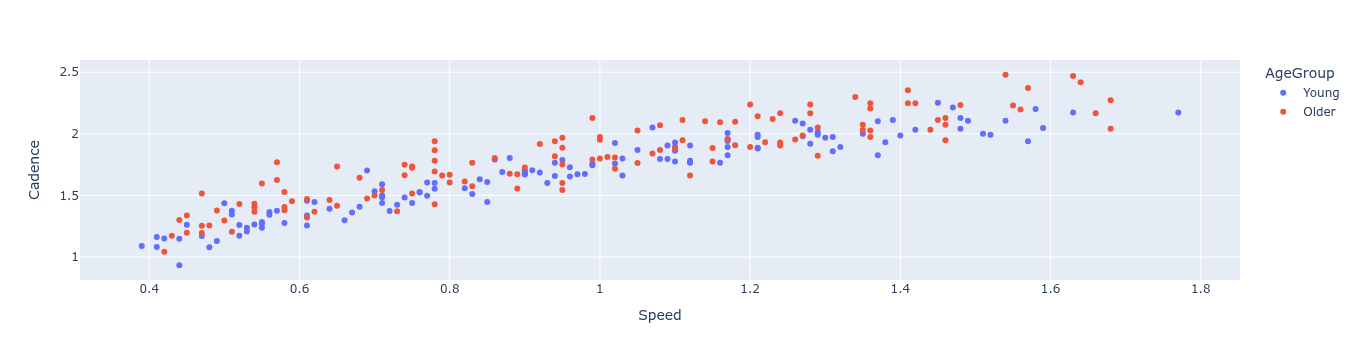

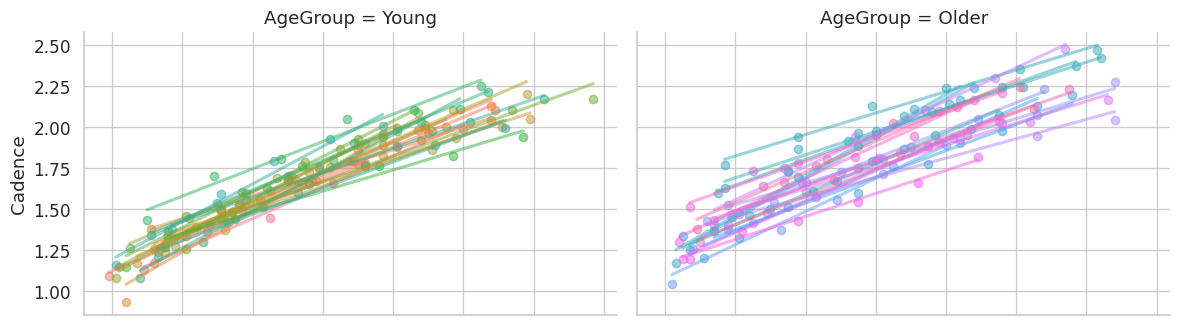

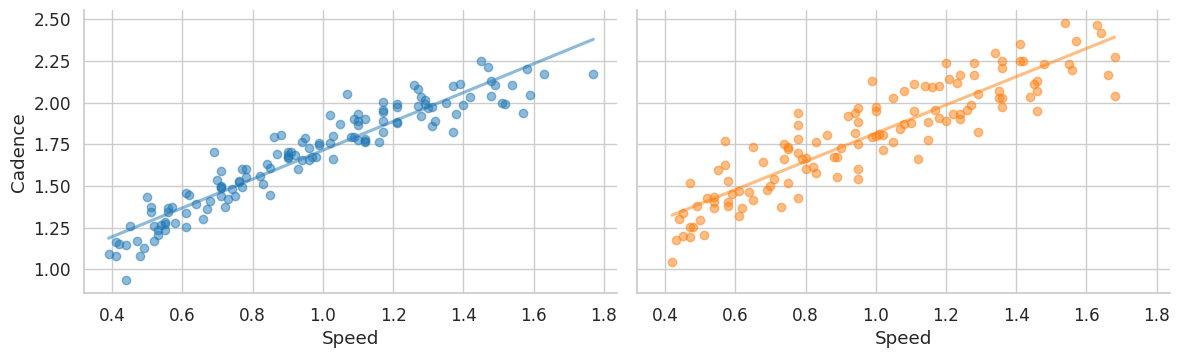

In [ ]:
plots(df, x='Speed', y='Cadence')

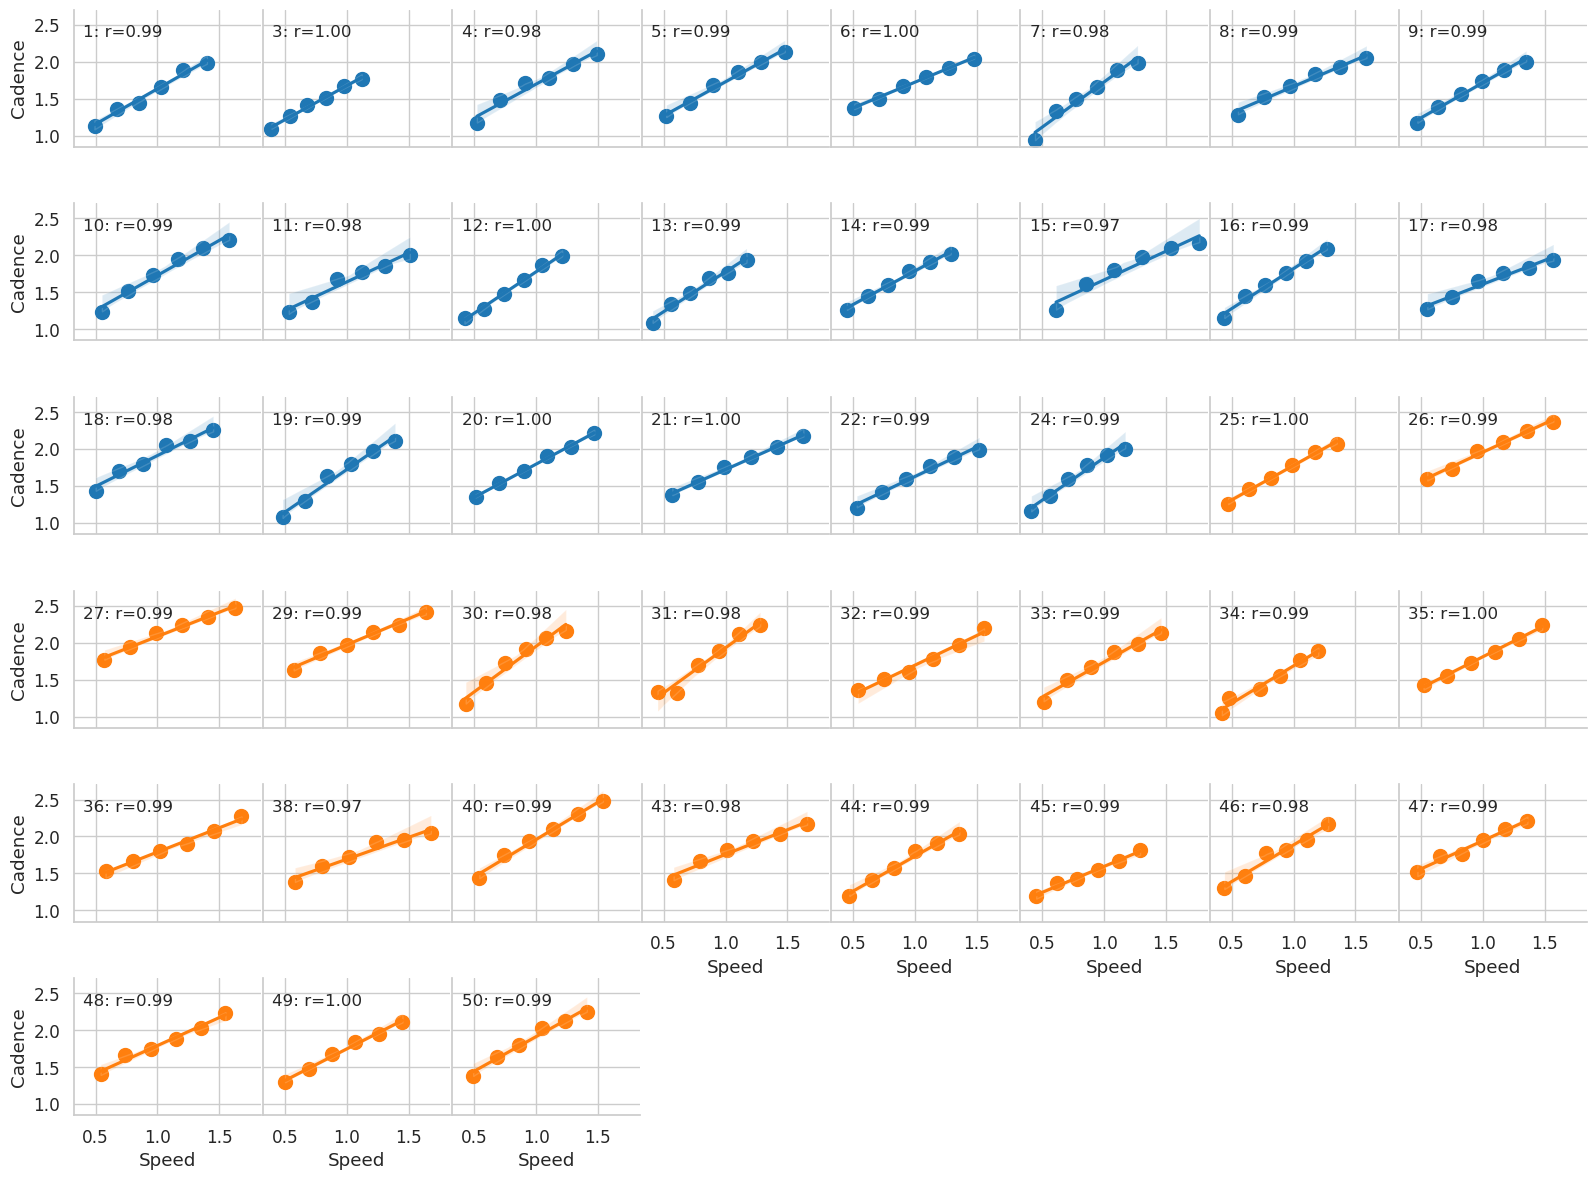

In [ ]:
plots2(df, x='Speed', y='Cadence')

#### Quadratic polynomial for the relation between variables Speed and Cadence

A parabola (quadratic polynomial) captures better the relation between variables Speed and Cadence:

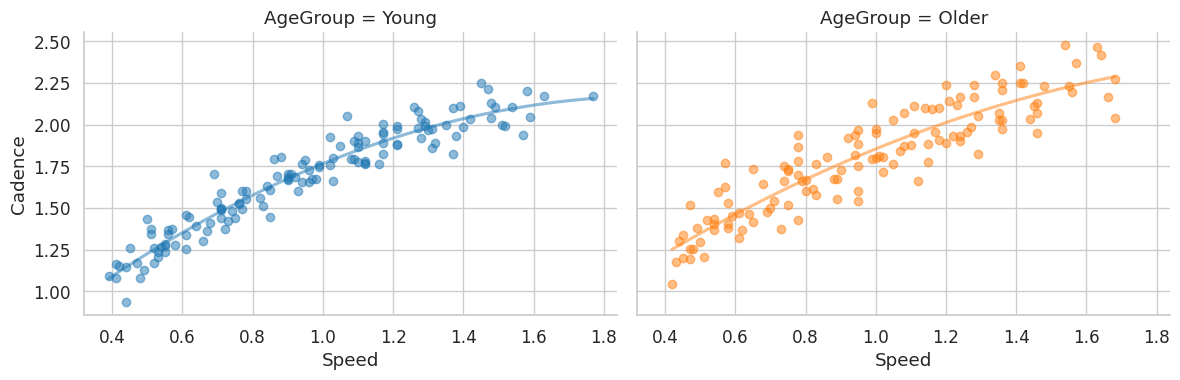

In [ ]:
grid = sns.lmplot(x='Speed', y='Cadence', data=df, order=2, col='AgeGroup', hue='AgeGroup',
                  ci=None, robust=False, scatter_kws={'alpha':.5}, line_kws={'alpha':.5},
                  facet_kws={'sharex':True, 'sharey':True}, fit_reg=True, legend=False,
                  height=4, aspect=1.5)
plt.show()

### A linear mixed-effects regression model

Linear mixed-effects regression models were employed to examine the effects of factors age and speed on the responses step length and cadence.   
We will fit models that express the mean value across subjects of the response as a linear function of age and speed (separately, added, and multiplied) with a random intercept and fixed slope for each subject. Such models are necessary because each subject walked at six different speeds with respect to his/her own comfortable speed (and because each subject had a different comfortable speed, the speed values varied continuously across all subjects).  
Accordingly, the following equation is the most general model to be used:

$$
\text{Response} = \beta_0 + \beta_A \text{AgeGroup} + \beta_S \text{Speed} + \beta_{S2} \text{Speed}\,^2 + \beta_{AS} \text{AgeGroup} \times \text{Speed}  + (1 | \text{Subject}) + \epsilon
$$

Where $(1|\text{Subject})$ is a random intercept for each subject, and $\epsilon$ is a residual error.

#### Replace letters by numeric values because it's easier to identify the effect  
E.g.: {'Y': 0, 'O': 1} implies that if there is an effect of Age and its coefficient (slope) is positive, it means that the response increases for older subjects and decreases for young subjects. Internally the letters were replaced by numbers anyway but we didn't know the order.

In [ ]:
df['AgeGroup'] = df['AgeGroup'].replace({'Young': 0, 'Older': 1}).astype(int)
#df['AgeGroup'] = df['AgeGroup'].cat.remove_unused_categories()

### Run regression models

In [ ]:
# https://stackoverflow.com/questions/31978948/python-stats-models-quadratic-term-in-regression
df['Speed2'] = df['Speed']**2

features = ['StepLength', 'Cadence']
labels   = ['StepLength', 'Cadence']

predictors = ['C(AgeGroup)',
              'Speed',
              'C(AgeGroup) + Speed',
              'Speed + Speed2',
              'C(AgeGroup) + Speed + Speed2',
              'C(AgeGroup) * Speed',
              'C(AgeGroup) * Speed + Speed2']
groups = df['Subject']

names = ['C(AgeGroup)[T.1]', 'Speed', 'Speed2', 'C(AgeGroup)[T.1]:Speed']
models, fit_ml, fit_re = runmodels(df, predictors, features, groups, names)

Running regression models...
StepLength C(AgeGroup)
Model  0: StepLength ~ C(AgeGroup) converged.
StepLength Speed
Model  1: StepLength ~ Speed converged.
StepLength C(AgeGroup) + Speed
Model  2: StepLength ~ C(AgeGroup) + Speed converged.
StepLength Speed + Speed2
Model  3: StepLength ~ Speed + Speed2 converged.
StepLength C(AgeGroup) + Speed + Speed2
Model  4: StepLength ~ C(AgeGroup) + Speed + Speed2 converged.
StepLength C(AgeGroup) * Speed
Model  5: StepLength ~ C(AgeGroup) * Speed converged.
StepLength C(AgeGroup) * Speed + Speed2
Model  6: StepLength ~ C(AgeGroup) * Speed + Speed2 converged.
Cadence C(AgeGroup)
Model  7: Cadence ~ C(AgeGroup) converged.
Cadence Speed
Model  8: Cadence ~ Speed converged.
Cadence C(AgeGroup) + Speed
Model  9: Cadence ~ C(AgeGroup) + Speed converged.
Cadence Speed + Speed2
Model 10: Cadence ~ Speed + Speed2 converged.
Cadence C(AgeGroup) + Speed + Speed2
Model 11: Cadence ~ C(AgeGroup) + Speed + Speed2 converged.
Cadence C(AgeGroup) * Speed
Model 1

In [ ]:
display(fit_re[0].summary())
display(fit_re[1].summary())
display(fit_re[2].summary())
display(fit_re[3].summary())

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  StepLength
No. Observations:  258      Method:              REML      
No. Groups:        43       Scale:               0.0122    
Min. group size:   6        Log-Likelihood:      195.0126  
Max. group size:   6        Converged:           Yes       
Mean group size:   6.0                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.553    0.010 56.561 0.000  0.534  0.573
C(AgeGroup)[T.1] -0.022    0.014 -1.570 0.116 -0.049  0.005
Group Var         0.000    0.005                           
===========================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: StepLength
No. Observations: 258     Method:             REML      
No. Groups:       43      Scale:              0.0004    
Min. group size:  6       Log-Likelihood:     587.7459  
Max. group size:  6       Converged:          Yes       
Mean group size:  6.0                                   
---------------------------------------------------------
           Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  0.244     0.006  39.173  0.000   0.232   0.256
Speed      0.308     0.004  85.347  0.000   0.301   0.315
Group Var  0.001     0.015                               
========================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  StepLength
No. Observations:  258      Method:              REML      
No. Groups:        43       Scale:               0.0004    
Min. group size:   6        Log-Likelihood:      588.9091  
Max. group size:   6        Converged:           Yes       
Mean group size:   6.0                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.259    0.007 35.241 0.000  0.245  0.273
C(AgeGroup)[T.1] -0.031    0.009 -3.294 0.001 -0.049 -0.012
Speed             0.308    0.004 85.431 0.000  0.301  0.315
Group Var         0.001    0.012                           
===========================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: StepLength
No. Observations: 258     Method:             REML      
No. Groups:       43      Scale:              0.0003    
Min. group size:  6       Log-Likelihood:     589.0486  
Max. group size:  6       Converged:          Yes       
Mean group size:  6.0                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.216    0.011 20.192 0.000  0.195  0.237
Speed          0.372    0.020 18.341 0.000  0.332  0.412
Speed2        -0.032    0.010 -3.188 0.001 -0.052 -0.012
Group Var      0.001    0.015                           
========================================================

"""

####  Table with model results

In [ ]:
names2 = [['Age'], ['Speed'], ['Speed $\mathbf{^2}$'], ['Age × Speed']]
display_table(models, names2, filename='sl_c_age_speed.csv')

#### Partial regression plots

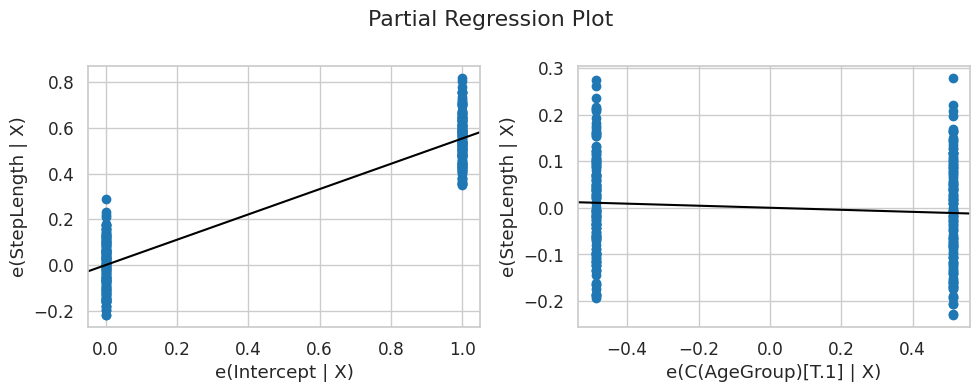

In [ ]:
fig = plt.figure(figsize=(10, 4))
fig = sm.graphics.plot_partregress_grid(fit_re[0], grid=(1, 2), fig=fig)
plt.tight_layout()

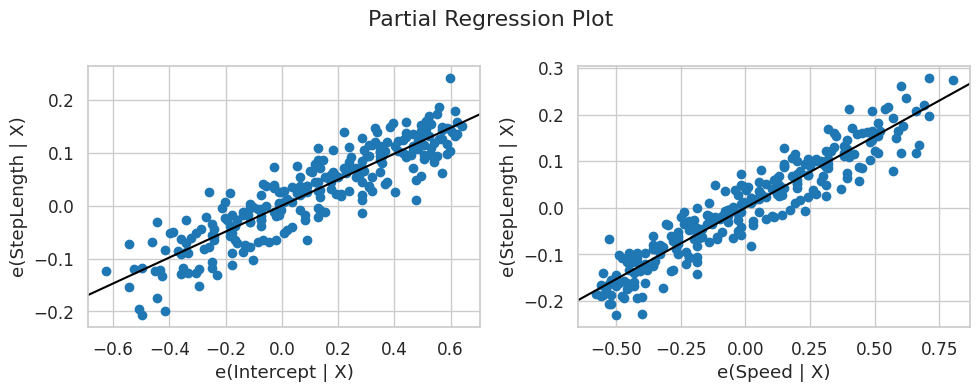

In [ ]:
fig = plt.figure(figsize=(10, 4))
fig = sm.graphics.plot_partregress_grid(fit_re[1], grid=(1, 2), fig=fig)
plt.tight_layout()

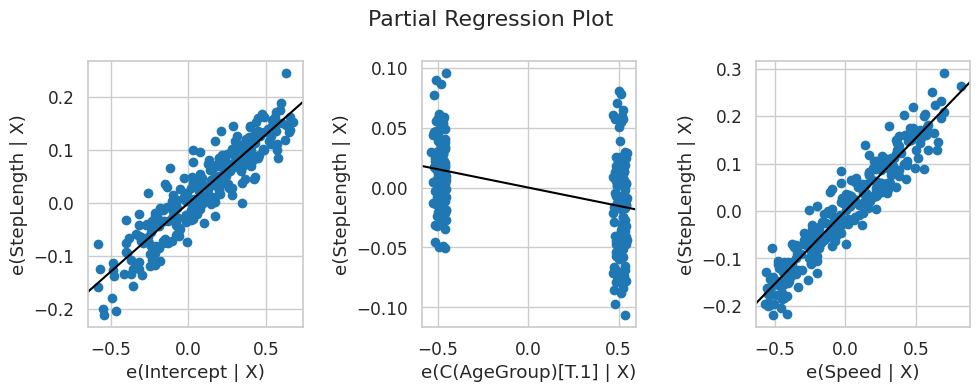

In [ ]:
fig = plt.figure(figsize=(10, 4))
sm.graphics.plot_partregress_grid(fit_re[2], grid=(1, 3), fig=fig)
plt.tight_layout()

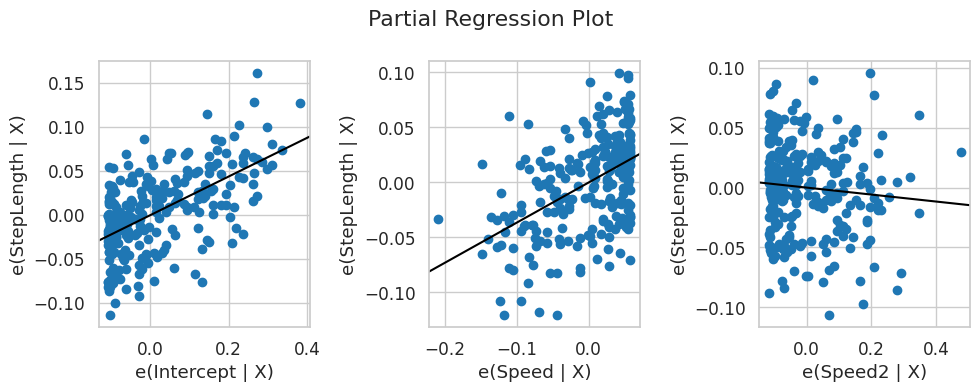

In [ ]:
fig = plt.figure(figsize=(10, 4))
sm.graphics.plot_partregress_grid(fit_re[3], grid=(1, 3), fig=fig)
plt.tight_layout()

#### Non-normality of residuals are due to a few outliers and don't affect regression results

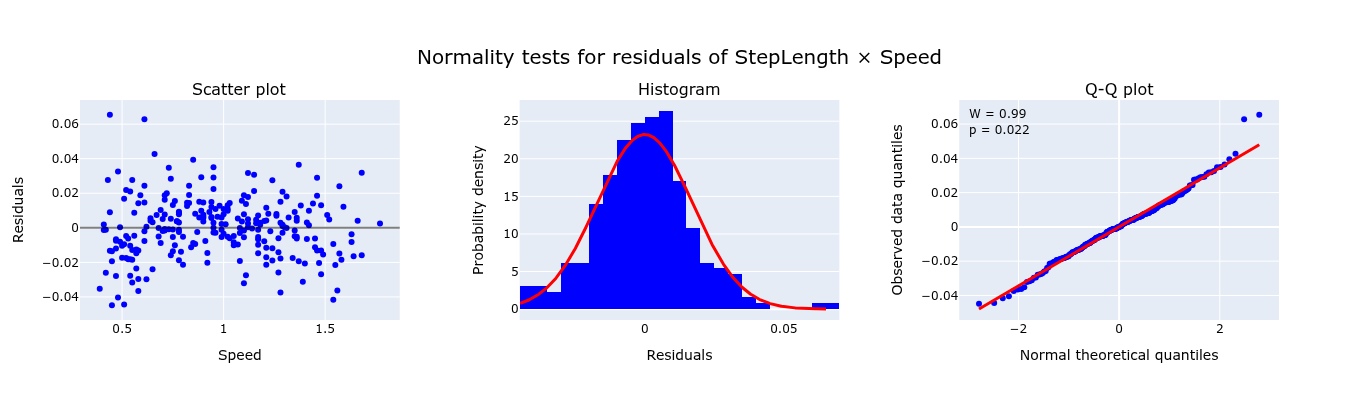

We reject the null hypothesis that the residuals come from a population with normal distribution
(Shapiro-Wilk test: W(258) = 0.99, p = 0.022).


In [ ]:
plot_residuals(fit=fit_re[1], kind='conditional', xlabel='Speed', ylabel='StepLength',
               hover=('Subject', df['Subject']));

In [ ]:
df2 = df.drop(index=df[(df.Subject == 7) | (df.Subject == 31) | (df.Subject == 39)].index, inplace=False)
groups = df2['Subject']
models, fit_ml, fit_re  = runmodels(df2, predictors, features, groups, names)
display_table(models, names2)

Running regression models...
StepLength C(AgeGroup)


/home/marcos/miniconda3/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning:

Random effects covariance is singular



Model  0: StepLength ~ C(AgeGroup) converged.
StepLength Speed
Model  1: StepLength ~ Speed converged.
StepLength C(AgeGroup) + Speed
Model  2: StepLength ~ C(AgeGroup) + Speed converged.
StepLength Speed + Speed2
Model  3: StepLength ~ Speed + Speed2 converged.
StepLength C(AgeGroup) + Speed + Speed2
Model  4: StepLength ~ C(AgeGroup) + Speed + Speed2 converged.
StepLength C(AgeGroup) * Speed
Model  5: StepLength ~ C(AgeGroup) * Speed converged.
StepLength C(AgeGroup) * Speed + Speed2
Model  6: StepLength ~ C(AgeGroup) * Speed + Speed2 converged.
Cadence C(AgeGroup)
Model  7: Cadence ~ C(AgeGroup) converged.
Cadence Speed
Model  8: Cadence ~ Speed converged.
Cadence C(AgeGroup) + Speed
Model  9: Cadence ~ C(AgeGroup) + Speed converged.
Cadence Speed + Speed2
Model 10: Cadence ~ Speed + Speed2 converged.
Cadence C(AgeGroup) + Speed + Speed2
Model 11: Cadence ~ C(AgeGroup) + Speed + Speed2 converged.
Cadence C(AgeGroup) * Speed
Model 12: Cadence ~ C(AgeGroup) * Speed converged.
Cadence 

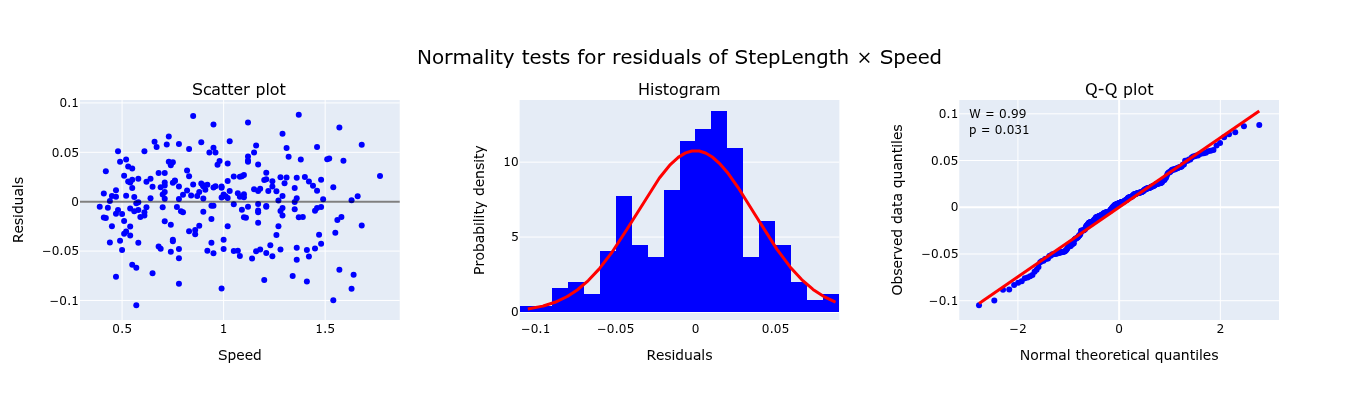

We reject the null hypothesis that the residuals come from a population with normal distribution
(Shapiro-Wilk test: W(246) = 0.99, p = 0.031).


In [ ]:
plot_residuals(fit=fit_re[1], kind='marginal', xlabel= 'Speed', ylabel='StepLength',
               hover=('Subject', df2['Subject']));

### Confidence intervals for the mean by bootstrap

In [ ]:
m_ci = lambda x: [np.mean(x), *pg.compute_bootci(x, y=None, func='mean', decimals=5, seed=0)]
s_comf_ci = df.drop_duplicates(subset='Subject').groupby('AgeGroup')['SpeedComf'].apply(m_ci)
s_comf_ci = pd.DataFrame(s_comf_ci.to_list(), index=s_comf_ci.index, columns=['mean', 'pinf', 'psup'])
s_comf_ci

,mean,pinf,psup
AgeGroup,,,
0,1.232,1.175,1.290
1,1.269,1.214,1.322


In [ ]:
if not 'sl_d' in data_dict.keys():
    # create data with speed values to predict step length
    speed = np.r_[np.linspace(df[df['AgeGroup']==0]['Speed'].min(),
                              df[df['AgeGroup']==0]['Speed'].max(), num=100),
                  np.linspace(df[df['AgeGroup']==1]['Speed'].min(),
                              df[df['AgeGroup']==1]['Speed'].max(), num=100)]
    agegroup = np.r_[np.zeros(100), np.ones(100)]
    df3 = pd.DataFrame({'Speed': speed, 'AgeGroup': agegroup})
    # bootstrap regression data
    y = bootstrap(df[['Subject', 'AgeGroup', 'Speed', 'StepLength']], df3,
                  'StepLength', 'Speed + C(AgeGroup)', 'Subject', n_boots=n_boots)
    # create data with bootstrapped parameters
    df4 = pd.DataFrame({'AgeGroup': agegroup,
                        'Speed': speed,
                        'StepLength': np.mean(y, axis=1),  # np.percentile(y, 50, axis=1),
                        'pinf': np.percentile(y, 100*alpha/2, axis=1),
                        'psup': np.percentile(y, 100*(1-alpha/2), axis=1)})
    # Values at comfortable speed
    speed_comf = df['SpeedComf'].mean()
    sl_comf = np.array([np.dot(fit_re[2].fe_params, [1, 0, speed_comf]),
                        np.dot(fit_re[2].fe_params, [1, 1, speed_comf])])
    sldiff_comf = (sl_comf[1] - sl_comf[0]) / sl_comf[0]*100
    # store data
    data_dict['sl_d'] = (df.copy(deep=True), df4.copy(deep=True), speed_comf, sl_comf, sldiff_comf, s_comf_ci.mean())
    print('Stride length difference at comfortable speed ({:.2f} m/s): {:.2f}%'.format(data_dict['sl_d'][2], data_dict['sl_d'][4]))
    # save data to a file
    try:
        data_file = open(f'{path2}{os.sep}data_dict.pkl', 'wb')
        pickle.dump(data_dict, data_file)
        data_file.close()
    except:
        print('Data not saved in the cloud.')

if not 'c_d' in data_dict.keys():
    # create data with speed values to predict cadence
    speed = np.r_[np.linspace(df[df['AgeGroup']==0]['Speed'].min(),
                              df[df['AgeGroup']==0]['Speed'].max(), num=100),
                  np.linspace(df[df['AgeGroup']==1]['Speed'].min(),
                              df[df['AgeGroup']==1]['Speed'].max(), num=100)]
    agegroup = np.r_[np.zeros(100), np.ones(100)]
    df3 = pd.DataFrame({'Speed': speed, 'AgeGroup': agegroup})
    # bootstrap regression data
    y = bootstrap(df[['Subject', 'AgeGroup', 'Speed', 'Cadence']], df3,
                  'Cadence', 'Speed + np.power(Speed, 2) + C(AgeGroup)', 'Subject', n_boots=n_boots)
    # create data with bootstrapped parameters
    df4 = pd.DataFrame({'AgeGroup': agegroup,
                        'Speed': speed,
                        'Cadence': np.mean(y, axis=1),  # np.percentile(y, 50, axis=1)
                        'pinf': np.percentile(y, 100*alpha/2, axis=1),
                        'psup': np.percentile(y, 100*(1-alpha/2), axis=1)})
    # Values at comfortable speed
    speed_comf = df['SpeedComf'].mean()
    c_comf = np.array([np.dot(fit_re[11].fe_params, [1, 0, speed_comf, speed_comf**2]),
                       np.dot(fit_re[11].fe_params, [1, 1, speed_comf, speed_comf**2])])
    cdiff_comf = (c_comf[1] - c_comf[0]) / c_comf[0]*100
    # store data
    data_dict['c_d'] = (df.copy(deep=True), df4.copy(deep=True), speed_comf, c_comf, cdiff_comf, s_comf_ci.mean())
    print('Cadence difference at comfortable speed ({:.2f} m/s): {:.2f}%'.format(data_dict['c_d'][2], data_dict['c_d'][4]))
    # save data to a file
    try:
        data_file = open(f'{path2}{os.sep}data_dict.pkl', 'wb')
        pickle.dump(data_dict, data_file)
        data_file.close()
    except:
        print('Data not saved in the cloud.')

100%|███████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.40it/s]


Stride length difference at comfortable speed (1.25 m/s): -4.49%


100%|███████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.78it/s]

Cadence difference at comfortable speed (1.25 m/s): 5.10%


## Two-dimensional plots combined: Step Length and Cadence versus Speed

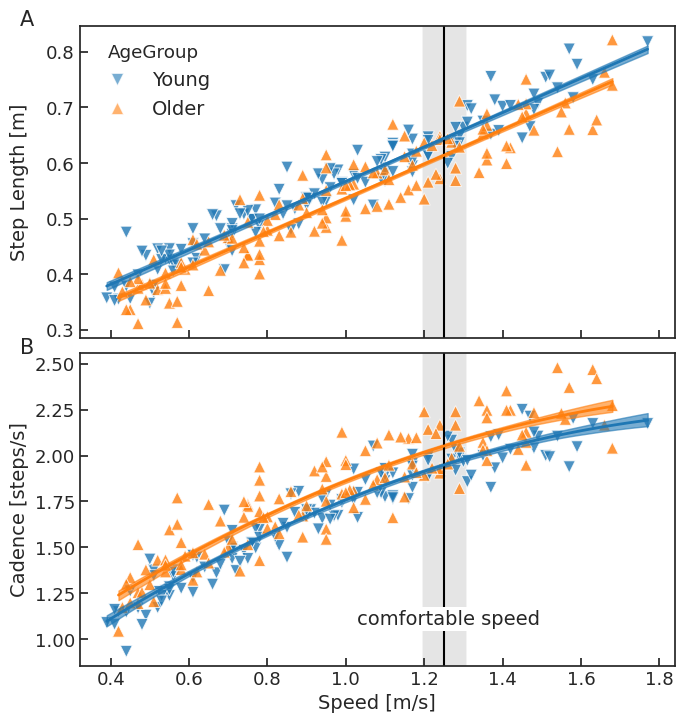

In [ ]:
# Convert back names for levels of factor Agegroup
for key in list(data_dict.keys()):
    data_dict[key][0]['AgeGroup'] = data_dict[key][0]['AgeGroup'].replace({0: 'Young', 1: 'Older'}).astype(str)

sns.set_style('white', rc={'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True,
                  'ytick.right': False, 'xtick.direction': 'in', 'ytick.direction': 'in'})
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7, 8))

fs = 14  # fontsize
ms = 75  # markersize
ab = ['A', 'B']

# data_dict keys:
keys = ['sl_d', 'c_d']
vrs = ['StepLength', 'Cadence']
# tuple: (df, df4, speed_comf, sl_comf, sldiff_comf, s_comf_ci.mean())
xlabels = ['Speed [m/s]', 'Speed [m/s]']
ylabels = ['Step Length [m]', 'Cadence [steps/s]']

axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.axvspan(data_dict[keys[i]][5].iloc[1], data_dict[keys[i]][5].iloc[2], facecolor='k', alpha=0.1)
    ax.axvline(data_dict[keys[i]][5].iloc[0], c='k', ls='-')
    df4 = data_dict[keys[i]][1]
    sns.scatterplot(x='Speed', y=vrs[i], data=data_dict[keys[i]][0], hue='AgeGroup',
                    style='AgeGroup', markers=['v', '^'], alpha=.8,
                    s=ms, ax=ax)
    ax.fill_between(df4[df4['AgeGroup']==0]['Speed'],
                    df4[df4['AgeGroup']==0]['pinf'], df4[df4['AgeGroup']==0]['psup'],
                    color=sns.color_palette()[0], alpha=.6)
    ax.fill_between(df4[df4['AgeGroup']==1]['Speed'],
                    df4[df4['AgeGroup']==1]['pinf'], df4[df4['AgeGroup']==1]['psup'],
                    color=sns.color_palette()[1], alpha=.6)
    sns.lineplot(x='Speed', y=vrs[i], data=df4, hue='AgeGroup',
                 errorbar=None, alpha=1, legend=False, lw=2, ax=ax)
    ax.tick_params(axis='both', labelsize=fs-1)
    ax.set_xlabel(xlabels[i], fontsize=fs)
    ax.set_ylabel(ylabels[i], fontsize=fs)
    ax.text(-0.1, 1, ab[i], fontsize=fs+1, transform=ax.transAxes)

axs[0].legend(title='AgeGroup', fontsize=fs, loc='upper left', frameon=False)
for lh in axs[0].get_legend().legend_handles:
    lh.set_alpha(.6)
    #lh._sizes = [40]
axs[1].get_legend().remove()
#text = 'mean comfortable speed\n({:.2f} m/s)'.format(data_dict[keys[2]][2])
text = 'comfortable speed'
axs[1].text(.62, .15, text, fontsize=fs, ha='center', va='center',
            bbox={'facecolor':'white', 'alpha':1, 'edgecolor':'none', 'pad':2},
            transform=axs[1].transAxes)
fig.align_labels()
plt.subplots_adjust(left=.1, bottom=.1, right=.95, top=.9, wspace=.1, hspace=.05)
try:
    fig.savefig(f'{path2}{os.sep}regressions__SL_C.png', dpi=600)
    fig.savefig(f'{path2}{os.sep}regressions__SL_C.svg', dpi=600)
except:
    print('Figure not saved in the cloud.')

plt.show()

Figure 2. Step Length (A) and Cadence (B) versus Speed of the young (N=22) and older (N=21) individuals, each subject walked at six different speeds. Regression models (± 95% confidence interval) are fitted for Step Length (first-degree polynomial) and Cadence (second-degree polynomial) versus Speed. Vertical line and shaded area indicate overall mean comfortable speed (± 95% confidence interval).

## Three-dimensional plots: Step Length and Cadence versus Speed

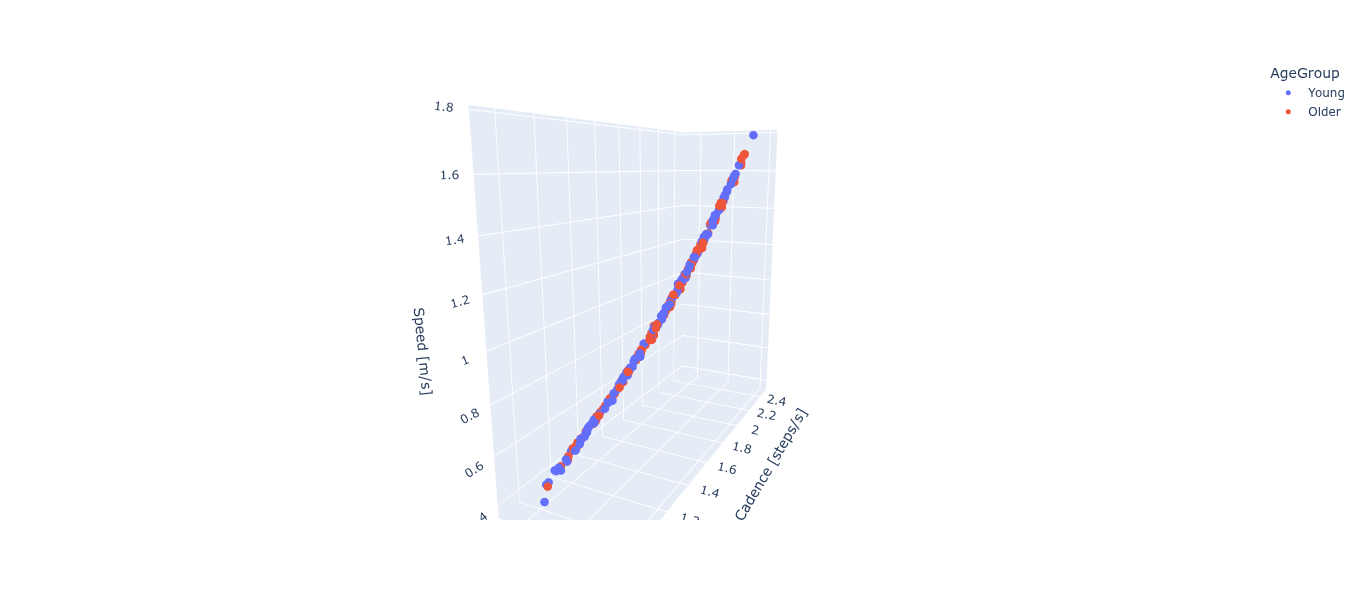

In [ ]:
# add plane: https://memotut.com/en/e42c726cdee25767105d/
df['AgeGroup'] = df['AgeGroup'].replace({0: 'Young', 1: 'Older'}).astype(str)
fig = px.scatter_3d(df, x='StepLength', y='Cadence', z='Speed', color='AgeGroup',
                    labels={'StepLength': 'Step Length [m]', 'Cadence': 'Cadence [steps/s]',
                            'Speed': 'Speed [m/s]'},
                    width=800, height=600)
fig.update_traces(marker=dict(size=5), selector=dict(mode='markers'))
camera = dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=1, y=-2, z=0.5))
fig.update_layout(scene_camera=camera)
fig.show()

## References
 - C.A. Fukuchi, R.K. Fukuchi, M. Duarte, A public dataset of overground and treadmill walking kinematics and kinetics in healthy individuals, PeerJ. 6 (2018) e4640. https://doi.org/10.7717/peerj.4640.  